# IY011 Contrastive Learning: Model Training
Randomly pick pairs of samples from the dataset, randomly assign labels to each, and train a model to distinguish them

# === APPROACH 1: BASELINE CLASSIFIER (The "Memorizer") ===
```python
def baseline_pipeline(all_files):
    # 1. DATA GENERATION (Static & Large)
    # We load massive chunks of data (e.g., 500 trajectories) from just a few files.
    # Negative Group (label = 0) = [File A, File B],  Positive Group (label = 1) = [File C]
    groups = build_large_groups(all_files, num_groups=8, trajs_per_group=500)

    # 2. DATA PREPARATION (The "Dismantling" Step)
    dataset = []
    for group_trajs, group_label in groups:
        for trajectory in group_trajs:
            # CRITICAL FLAW: We strip the trajectory away from its group context.
            # The model sees a single signal and asks "Which group are you?"
            # It solves this by memorizing: "Mean=50 -> Group 0" (Memorizing File A)
            dataset.append((trajectory, group_label))

    # 3. SPLITTING (The Leakage Step)
    # We shuffle ALL samples together.
    # Result: Siblings from "File A" end up in BOTH Train and Test.
    # The model cheats on the test set because it has already memorized File A.
    train_data, test_data = random_split(dataset, test_size=0.2)

    # 4. PREPROCESSING (The "Squashing" Step)
    # Standard scaling on raw values squashes low-mean signals (Mu=10 vs 50) into noise.
    scaler.fit(train_data) 
    train_data = scaler.transform(train_data)

    # 5. MODEL ARCHITECTURE
    model = StandardTransformerClassifier()
    # Input:  (Batch, Time, 1) -> Single Trajectory
    # Output: (Batch, 2)       -> Class Logits

    # 6. TRAINING LOOP
    for x, label in train_loader:
        logits = model(x)
        loss = BCEWithLogitsLoss(logits, label)
        loss.backward()

In [1]:
import os
import subprocess
import glob
import tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import time
# plotting 
import matplotlib.pyplot as plt
from visualisation.plots import plot_mRNA_dist, plot_mRNA_trajectory
# ml
import torch, itertools
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from models.transformer import TransformerClassifier
from training.eval import evaluate_model
from training.train import train_model 

# data handling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Build groups
from utils.data_processing import build_groups

import wandb
%load_ext autoreload
%autoreload 2  

In [2]:
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data")
RESULTS_PATH = DATA_ROOT / "IY011_simulation_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
# TRAJ_PATH = [DATA_ROOT / f"mRNA_trajectories_mu{row['mu_target']:.3f}_cv{row['cv_target']:.3f}_tac{row['t_ac_target']:.3f}.csv" for idx, row in df_params.iterrows()] # the trajectories 
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]

# extract meta data
parameter_sets = [{
    'sigma_b': row['sigma_b'],
    'sigma_u': row['sigma_u'],
    'rho': row['rho'],
    'd': row['d'],
    'label': 0
} for idx, row in df_params.iterrows()]
time_points = np.arange(0, 3000, 1.0)
size = 1000

In [11]:
num_traj = 2
NUM_GROUPS = 20000

groups = build_groups(TRAJ_NPZ_PATH, num_groups=NUM_GROUPS, num_traj=num_traj) # list of tuples (X, y)

Building negative groups: 100%|██████████| 10000/10000 [00:00<00:00, 19292.82it/s]


## Data Prep

In [12]:
def data_prep(groups, batch_size):
    # Stacked groups -> individual trajectory samples
    X_samples = []
    y_samples = []
    for Xg, yg in groups:          # Xg shape (seq_len, K)
        L, K = Xg.shape
        for k in range(K):
            X_samples.append(Xg[:, k:k+1])  # (seq_len, 1)
            y_samples.append(yg)            # or some other per-trajectory label
    X_samples = np.stack(X_samples, 0)      # (N_samples, seq_len, 1)
    y_samples = np.array(y_samples)
    print(f'X_samples shape: {X_samples.shape}, y_samples shape: {y_samples.shape}')

    # with the stacked samples
    X_train, X_test, y_train, y_test = train_test_split(
        X_samples, y_samples, test_size=0.2, random_state=42, stratify=y_samples
    )
    X_train, X_val,  y_train, y_val  = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print("Data preparation:")
    print(f"  Train groups: {len(y_train)}, Val groups: {len(y_val)}, Test groups: {len(y_test)}")
    # === Standardise features (across time*batch, per-channel) ===
    scaler = StandardScaler()

    # Reshape 3D data to 2D for scaling
    original_shape_train = X_train.shape
    original_shape_val = X_val.shape
    original_shape_test = X_test.shape

    # Reshape to 2D: (batch * seq_len, features)
    X_train_2d = X_train.reshape(-1, X_train.shape[-1])
    X_val_2d = X_val.reshape(-1, X_val.shape[-1])
    X_test_2d = X_test.reshape(-1, X_test.shape[-1])

    # Scale the data
    X_train_2d = scaler.fit_transform(X_train_2d)
    X_val_2d = scaler.transform(X_val_2d)
    X_test_2d = scaler.transform(X_test_2d)

    # Reshape back to 3D
    X_train = X_train_2d.reshape(original_shape_train)
    X_val = X_val_2d.reshape(original_shape_val)
    X_test = X_test_2d.reshape(original_shape_test)

    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    print("X_test shape:", X_test.shape)

    # === Convert to tensors and loaders ===
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,   dtype=torch.long)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,  dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
    val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # check the data loaders
    for X_batch, y_batch in train_loader:
        print(X_batch.shape, y_batch.shape)
        break 
    
    return train_loader, val_loader, test_loader, scaler

## Transformer Model Eval
start by defining some model & training hyperparameters

In [13]:
# === Dataloader hyperparams & data prep ===
batch_size = 64
train_loader, val_loader, test_loader, scaler = data_prep(groups, batch_size)
# === Dataloader hyperparams & data prep ===

X_samples shape: (40000, 1811, 1), y_samples shape: (40000,)
Data preparation:
  Train groups: 25600, Val groups: 6400, Test groups: 8000


X_train shape: (25600, 1811, 1)
X_val shape: (6400, 1811, 1)
X_test shape: (8000, 1811, 1)
torch.Size([64, 1811, 1]) torch.Size([64])


In [14]:
X_b, y_b = next(iter(train_loader))
print(X_b.shape, y_b.shape)

torch.Size([64, 1811, 1]) torch.Size([64])


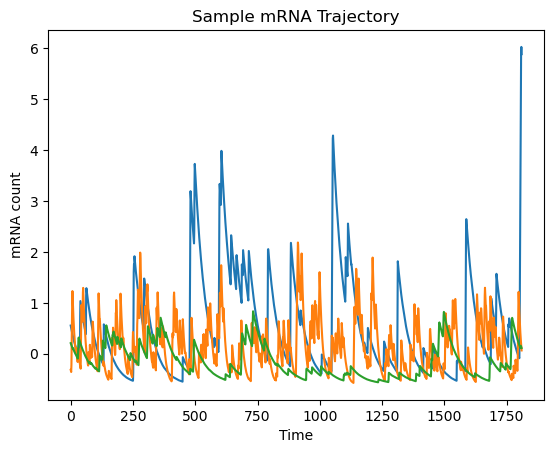

In [15]:
#plot the X_b
plt.plot(X_b[0,:,0].numpy())
plt.plot(X_b[1,:,0].numpy())
plt.plot(X_b[2,:,0].numpy())
plt.xlabel('Time')
plt.ylabel('mRNA count')
plt.title('Sample mRNA Trajectory')
plt.show()

In [16]:
# === Model hyperparams ===
input_size = 1
num_classes = 2
d_model=64
nhead=4
num_layers=2
dropout=0.001
use_conv1d=False 

model = TransformerClassifier(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout, 
    use_conv1d=use_conv1d 
)
# === Model hyperparams ===

# === Training hyperparams ===
epochs = 50
patience = 10
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

### schedulers ### 
# 1. simple scheduler choice
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5) 

# 2. cosine scheduler with warmup, most commonly used for transformer
total_steps = epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)   # 10% warmup (good default)
#  (from huggingface)
from transformers import get_cosine_schedule_with_warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
) 

loss_fn = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip = 1.0
save_path = None
verbose = True

model.to(device)
# === Training hyperparams ===

TransformerClassifier(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (pe): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.001, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.001, inplace=False)
        (dropout2): Dropout(p=0.001, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.001, inplace=False)
  (head): Linear(in_features=64, out_features=2, bias=True)
)

wandb logging setup: 
1. set `wandb_logging=True` in `train_model` function call to enable logging
2. pass `wandb_config` dictionary to log hyperparameters

In [17]:
# === wandb config (required for tracking within train_model) ===
wandb_config = {
    "entity": "grignard-reagent",
    "project": "IY011-contrastive-learning",
    "name": f"groups_{NUM_GROUPS}_traj_{num_traj}_batch_size_{batch_size}", # change this to what you want
    "dataset": DATA_ROOT.name,
    "batch_size": batch_size,
    "input_size": input_size,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "num_classes": num_classes,
    "dropout": dropout,
    "use_conv1d": use_conv1d,
    "epochs": epochs,
    "patience": patience,
    "lr": lr,
    "optimizer": type(optimizer).__name__,
    "scheduler": type(scheduler).__name__,
    "loss_fn": type(loss_fn).__name__,
    "model": type(model).__name__,
    "batch_size": train_loader.batch_size,
    "num_traj_per_group": num_traj,
    "num_groups": NUM_GROUPS,
}
# === wandb config === 

Using modularised code for training and eval

In [ ]:
history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    patience=patience,
    lr=lr,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    grad_clip=grad_clip,
    save_path=save_path,
    verbose=verbose,
    wandb_logging=True, # this enables wandb logging within train_model
    wandb_config=wandb_config, # pass the config dictionary
)

Starting training...


KeyboardInterrupt: 

socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.


Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f37a98b6ed0>> (for post_run_cell):


socket.send() raised exception.


ConnectionResetError: Connection lost

socket.send() raised exception.
socket.send() raised exception.


socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.s

## Save / Load Model

In [10]:
# save the trained model
# model_path = "IY011_contrastive_model_1.pth"
# torch.save(model.state_dict(), model_path)

In [11]:
# load the siamese model
model = model = TransformerClassifier(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout, 
    use_conv1d=use_conv1d 
)
model_path =  "IY011_contrastive_model_1.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

TransformerClassifier(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (pe): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.001, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.001, inplace=False)
        (dropout2): Dropout(p=0.001, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.001, inplace=False)
  (head): Linear(in_features=64, out_features=2, bias=True)
)

## Eval

In [12]:
# evaluate on test set
test_loss, test_acc = evaluate_model(
    model,
    test_loader,
    loss_fn,
    device,
)

Test — loss: 0.27 | acc: 0.93


In [14]:
# predict probabilities on test set
from training.eval import predict_proba, _compute_probabilities
probs, targets = predict_proba(model, test_loader, loss_fn, device)

In [15]:
model.eval()
all_probs = []
all_targets = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)                               # raw logits
        probs = _compute_probabilities(logits, loss_fn) # (0,1)

        all_probs.append(probs.cpu())
        all_targets.append(y.cpu())

all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)

print(all_probs[:10])


tensor([9.9999e-01, 9.4904e-10, 2.1524e-12, 9.9970e-01, 9.9990e-01, 6.6747e-14,
        9.9999e-01, 1.7168e-11, 2.6717e-09, 9.9999e-01])


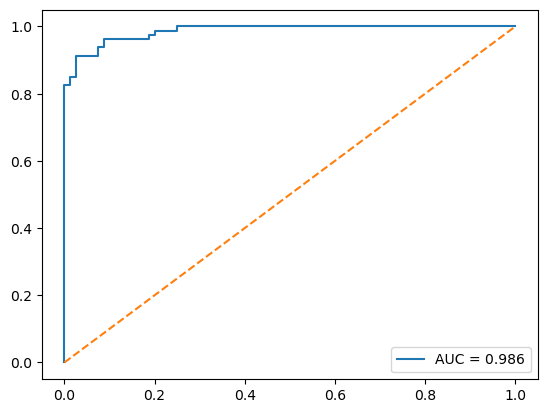

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probs = all_probs.numpy()
targets = all_targets.numpy()

fpr, tpr, _ = roc_curve(targets, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.show()


## Test on unseen data

In [69]:
from simulation.mean_cv_t_ac import find_tilda_parameters
from simulation.julia_simulate_telegraph_model import simulate_telegraph_model

# ==========================================
# 1. GENERATE UNSEEN DATA
# ==========================================
def generate_unseen_classes(n_classes=5, n_trajs_per_class=20, seq_len=3000):
    """
    Generates N new 'mystery' datasets with random parameters.
    Returns a list of dictionaries, each representing a unique biological condition.
    """
    print(f"Generating {n_classes} unseen classes...")
    unseen_data = []
    
    # Randomly sample parameters (Mu, CV, Tac)
    # We pick ranges similar to your training data to ensure they are valid biological possibilities
    mus = np.random.uniform(10, 100, n_classes)
    cvs = np.random.uniform(0.5, 2.0, n_classes)
    tacs = np.random.uniform(5, 50, n_classes)
    
    time_points = np.arange(0, seq_len, 1.0)

    for i in range(n_classes):
        try:
            # 1. Solve for physical parameters
            rho, d, sigma_b, sigma_u = find_tilda_parameters(mus[i], tacs[i], cvs[i])
            
            # 2. Simulate
            params = [{"sigma_b": sigma_b, "sigma_u": sigma_u, "rho": rho, "d": d, "label": 0}]
            df = simulate_telegraph_model(params, time_points, n_trajs_per_class)
            
            # 3. Extract clean array (N_trajs, Time)
            # Assuming format: columns t_0...t_T, rows are trajectories
            # Adjust filtering based on your exact df structure
            trajs = df.drop(columns=['label'], errors='ignore').values
            
            unseen_data.append({
                "class_id": f"Mystery_Class_{i}",
                "parameters": {"mu": mus[i], "cv": cvs[i], "tac": tacs[i]},
                "trajectories": trajs
            })
            print(f"  Generated Class {i}: Mu={mus[i]:.1f}, CV={cvs[i]:.2f}")
            
        except Exception as e:
            print(f"  Skipped a class due to solver error: {e}")
            
    return unseen_data

# === RUN GENERATION ===
unseen_datasets = generate_unseen_classes(n_classes=5, n_trajs_per_class=20)

Generating 5 unseen classes...
Using 12 threads for Julia simulation..
  Generated Class 0: Mu=41.3, CV=1.10
Using 12 threads for Julia simulation..
  Generated Class 1: Mu=69.8, CV=0.73
Using 12 threads for Julia simulation..
  Generated Class 2: Mu=81.6, CV=1.99
Using 12 threads for Julia simulation..
  Generated Class 3: Mu=93.4, CV=1.89
Using 12 threads for Julia simulation..
  Generated Class 4: Mu=31.1, CV=1.31


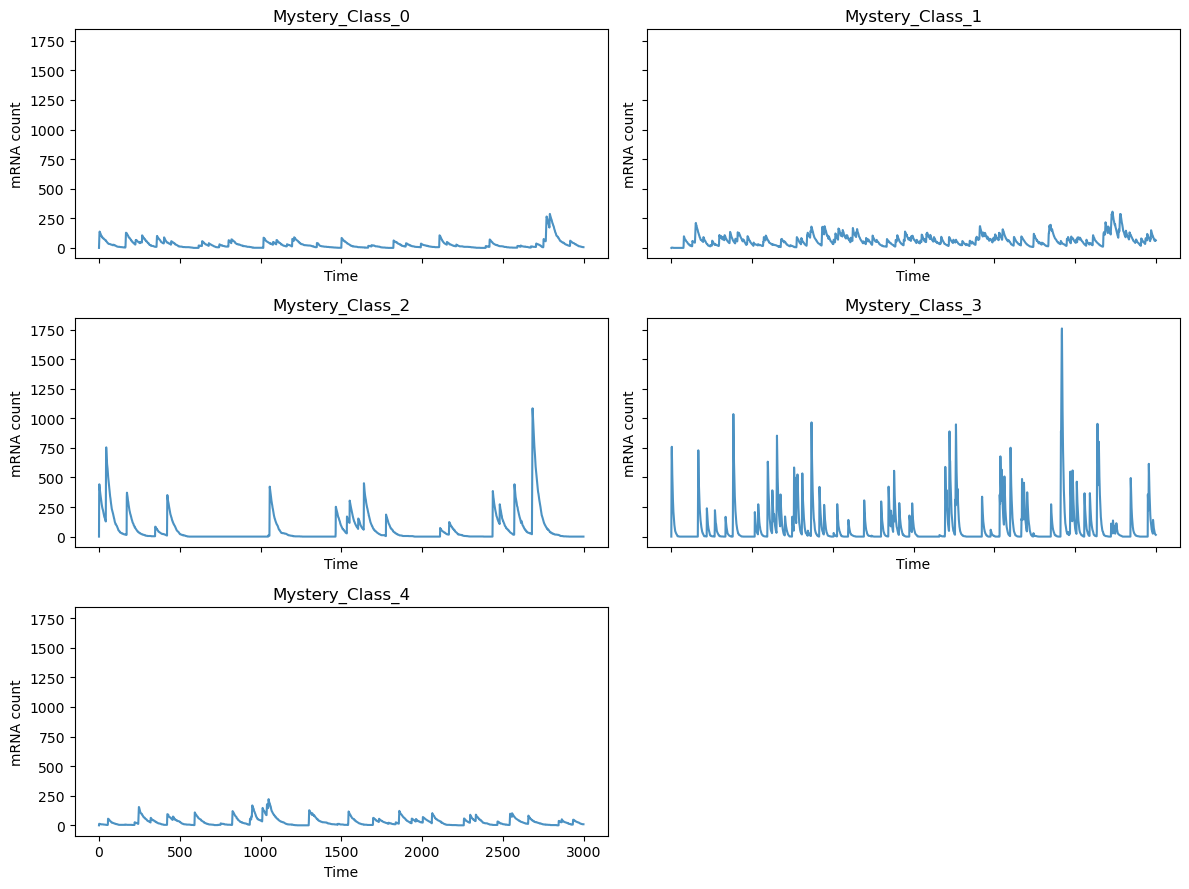

In [70]:
# subplot each unseen class separately to reduce crowding
n = len(unseen_datasets)
cols = 2
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

for i, unseen in enumerate(unseen_datasets):
    traj = unseen['trajectories'][0, :]
    t = time_points[:traj.shape[0]]
    axes[i].plot(t, traj, alpha=0.8)
    axes[i].set_title(unseen['class_id'])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('mRNA count')

# hide any extra subplots
for j in range(n, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 2. EVALUATE BASELINE MODEL
# ==========================================
def test_baseline_performance(model, unseen_data, scaler, crop_len=1811):
    """
    Tests the Baseline Model on unseen classes using One-Shot Classification.
    Since the Baseline doesn't know the new classes, we use it as a Feature Extractor.
    
    """
    model.eval()
    device = next(model.parameters()).device
    
    correct = 0
    trials = 0
    
    print(f"\n=== Testing Baseline Model (Feature Distance) ===")
    
    # --- Phase 1: Build Reference Library (Support Set) ---
    # We calculate the (Mean Embedding) for each new class
    class_mean_embedding = {}
    class_labels = []
    
    for data in unseen_data:
        # Take first 5 trajectories as 'Known References'
        refs = data['trajectories'][:5] 
        
        # 1. Preprocessing (Baseline Style: Linear Scale)
        N, T = refs.shape
        scaled = scaler.transform(refs.reshape(-1, 1)).reshape(N, T)
        
        # 2. Crop to input size
        # Taking the beginning of the signal
        crops = scaled[:, :crop_len]
        
        # 3. Extract Features
        tensor = torch.tensor(crops, dtype=torch.float32).unsqueeze(-1).to(device) # (N, T, 1)
        
        with torch.no_grad():
            # Use .encode() to get the vector before the classification head
            embeddings = model.encode(tensor).cpu().numpy() # (N, d_model)
            
        # 4. Calculate Mean Embedding (Mean Vector)
        mean_embedding = np.mean(embeddings, axis=0)
        class_mean_embedding[data['class_id']] = mean_embedding
        
    print(f"✅ Learned embeddings for {len(class_mean_embedding)} mystery classes.")

    # --- Phase 2: Classification (Query Set) ---
    # We test on the remaining trajectories
    for data in unseen_data:
        true_class = data['class_id']
        queries = data['trajectories'][5:] 
        
        for query_raw in queries:
            # 1. Prepare Query (Random Crop)
            if query_raw.shape[0] > crop_len:
                start = np.random.randint(0, query_raw.shape[0] - crop_len)
                query_crop = query_raw[start : start+crop_len]
            else:
                query_crop = np.pad(query_raw, (0, crop_len - len(query_raw)), mode='edge')
            
            # 2. Preprocess (Linear Scale)
            query_scaled = scaler.transform(query_crop.reshape(-1, 1)).reshape(crop_len)
            query_tensor = torch.tensor(query_scaled, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            
            # 3. Extract Query Feature
            with torch.no_grad():
                query_vec = model.encode(query_tensor).flatten().cpu().numpy()
            
            # 4. Nearest Neighbor Classification
            # Find which Class Mean Embedding is closest (Euclidean Distance)
            best_dist = float('inf')
            predicted_class = None
            
            for class_id, mean_embedding in class_mean_embedding.items():
                dist = np.linalg.norm(query_vec - mean_embedding)
                if dist < best_dist:
                    best_dist = dist
                    predicted_class = class_id
            
            # 5. Verdict
            if predicted_class == true_class:
                correct += 1
            trials += 1

    acc = correct / trials if trials > 0 else 0
    print(f"Baseline Accuracy on Unseen Data: {acc:.2%}")
    return acc

In [118]:
acc = test_baseline_performance(model, unseen_datasets, scaler)


=== Testing Baseline Model (Feature Distance) ===
✅ Learned embeddings for 5 mystery classes.
Baseline Accuracy on Unseen Data: 57.33%


## SVM Model Benchmark


In [64]:
def extract_data_for_svm(loader):
    """
    Extracts all batches from a DataLoader and flattens them for SVM input.
    Input X: (Batch, Time, Features) -> Output X: (Total_Samples, Time * Features)
    """
    X_list = []
    y_list = []
    
    print(f"Extracting data from loader for SVM...")
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            # Move to CPU and convert to numpy
            X_np = X_batch.cpu().numpy()
            y_np = y_batch.cpu().numpy()
            
            # Flatten the time series: 
            # (Batch, Seq_Len, 1) -> (Batch, Seq_Len)
            # This turns the time series into a long feature vector
            X_flat = X_np.reshape(X_np.shape[0], -1)
            
            X_list.append(X_flat)
            y_list.append(y_np)
            
    # Concatenate all batches
    return np.vstack(X_list), np.concatenate(y_list)

In [119]:
from classifiers.svm_classifier import svm_classifier

# 1. Extract Data dynamically from your loaders
X_train_svm, y_train_svm = extract_data_for_svm(train_loader)
X_test_svm, y_test_svm   = extract_data_for_svm(test_loader)

print(f"SVM Train Shape: {X_train_svm.shape}")
print(f"SVM Test Shape:  {X_test_svm.shape}")

# 2. Run the SVM Classifier
svm_accuracy = svm_classifier(
    X_train_svm,
    X_test_svm,
    y_train_svm,
    y_test_svm,
)

Extracting data from loader for SVM...


Extracting data from loader for SVM...
SVM Train Shape: (512, 1811)
SVM Test Shape:  (160, 1811)
=== SVM (RBF Kernel) Classification Accuracy: 0.84 ===


## Permutation Test

In [120]:
import torch
import numpy as np
from copy import deepcopy

def run_permutation_test(model, test_loader, device='cpu'):
    """
    Evaluates the model on:
    1. Original Data (Preserves Temporal Patterns)
    2. Shuffled Data (Destroys Temporal Patterns, Preserves Stats)
    """
    model.eval()
    model.to(device)
    
    acc_original = 0
    acc_shuffled = 0
    total = 0
    
    print("Running Permutation Test...")
    
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            
            # --- 1. Test on ORIGINAL (Ordered) ---
            logits_orig = model(X)
            preds_orig = torch.argmax(logits_orig, dim=1)
            acc_original += (preds_orig == y).sum().item()
            
            # --- 2. Test on SHUFFLED (Scrambled) ---
            # We shuffle the time dimension (dim=1) for each sample independently
            X_shuffled = X.clone()
            for i in range(X.shape[0]):
                # Generate random permutation indices
                idx = torch.randperm(X.shape[1])
                X_shuffled[i] = X[i, idx, :]
            
            logits_shuff = model(X_shuffled)
            preds_shuff = torch.argmax(logits_shuff, dim=1)
            acc_shuffled += (preds_shuff == y).sum().item()
            
            total += y.size(0)
            
    # Normalize
    acc_original /= total
    acc_shuffled /= total
    
    print(f"------------------------------------------------")
    print(f"Accuracy on ORIGINAL Data:  {acc_original:.2%}")
    print(f"Accuracy on SHUFFLED Data:  {acc_shuffled:.2%}")
    print(f"------------------------------------------------")
    
    # The Verdict
    if acc_shuffled > 0.8:
        print("🚨 VERDICT: MODEL IS CHEATING.")
        print("The model still works even when time is scrambled.")
        print("It is relying on Global Statistics (Identity), not Temporal Patterns.")
    elif acc_shuffled < 0.6:
        print("✅ VERDICT: MODEL IS LEGIT.")
        print("The model failed when time was scrambled.")
        print("It was relying on Temporal Patterns.")
    else:
        print("⚠️ VERDICT: MIXED.")
        print("The model uses a mix of stats and partial temporal features.")

# Run the test (assuming 'model' and 'test_loader' are loaded from _1.ipynb)
run_permutation_test(model, test_loader, device=device)

Running Permutation Test...


------------------------------------------------
Accuracy on ORIGINAL Data:  91.25%
Accuracy on SHUFFLED Data:  83.75%
------------------------------------------------
🚨 VERDICT: MODEL IS CHEATING.
The model still works even when time is scrambled.
It is relying on Global Statistics (Identity), not Temporal Patterns.


--
# Conclusion
1. The "Old Pipeline" Flaw: Data Flattening
In _1.ipynb (Cell 4), your data_prep function destroyed the contrastive pairs.

``` Python

# From IY011_contrastive_learning_model_training_1.ipynb
def data_prep(groups, batch_size):
    # ...
    for Xg, yg in groups:          # Xg is a group of trajectories (e.g. 500 from File A)
        L, K = Xg.shape
        for k in range(K):
            # PROBLEM: You strip the trajectory away from its partners
            X_samples.append(Xg[:, k:k+1])  
            y_samples.append(yg)            
    # ...
```

What the Model Saw:
- Input: A single trajectory $x$.
- Task: "Is this trajectory from a 'Positive Group' or a 'Negative Group'?"

Why this is impossible (in theory):
- A "Positive Group" (Label 1) contains trajectories from File A.
- A "Negative Group" (Label 0) contains trajectories from File A and File B.
- If the model receives a trajectory $x$ from File A, the correct label could be 1 OR 0. It is ambiguous.

Why it "Converged" (in practice): 

Your build_groups logic (with NUM_GROUPS=8) likely picked disjoint files for the positive and negative sets due to random sampling.

- Group 1 (Pos): File X (Label 1)
- Group 2 (Neg): File Y + File Z (Label 0)
- The model simply learned: "If it looks like File X, say 1. If it looks like File Y or Z, say 0."
- This is just standard classification. It memorized the specific $\mu$ and $CV$ of File X. It did not learn to compare signals. If you gave it a new File D, it would fail completely.

2. Why num_traj mattered in the Old Pipeline
You observed: "the only times the training loop fails to converge was due to when num_traj was set to 2"

- Reason: This was purely a Dataset Size issue.
    - With num_groups=8 and num_traj=2: Total data = 16 samples. Too small to train.
    - With num_groups=8 and num_traj=500: Total data = 4,000 samples. Enough to train.
    
It converged with high num_traj because you gave it enough data to memorize File X, not because the pipeline was correct for contrastive learning.